## Permutation Importance Analysis

Here we use permutation importance to analyze the importance of each feature in the StructuralDPPIV model. The permutation importance is calculated by the following steps:

In [1]:
import torch
new_tensor = torch.randn([6,4])
target_tensor = torch.ones(new_tensor.shape[0])
target_tensor = target_tensor.unsqueeze(1)
print(new_tensor)
print(target_tensor)
permutation_tensor = torch.cat((new_tensor[:,:3],target_tensor, new_tensor[:,3:]),1)
print(permutation_tensor)

tensor([[ 0.5626, -0.7419,  1.2144, -0.6606],
        [ 1.2828,  0.8220, -0.7697, -0.6885],
        [ 0.0071,  0.4041,  0.5677,  0.1571],
        [ 2.2381,  0.2617, -0.4841, -0.9488],
        [-0.4838,  0.1121, -0.1452, -2.1382],
        [-1.1116, -0.4883, -0.4934, -0.1940]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[ 0.5626, -0.7419,  1.2144,  1.0000, -0.6606],
        [ 1.2828,  0.8220, -0.7697,  1.0000, -0.6885],
        [ 0.0071,  0.4041,  0.5677,  1.0000,  0.1571],
        [ 2.2381,  0.2617, -0.4841,  1.0000, -0.9488],
        [-0.4838,  0.1121, -0.1452,  1.0000, -2.1382],
        [-1.1116, -0.4883, -0.4934,  1.0000, -0.1940]])


# Basic imports and settings

In [7]:
import os
import sys
import argparse
sys.path.append("/mnt/8t/jjr/Structural-DPP-IV")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# from model import StructuralDPPIV
from config import load_config
from config.load_constant import constant
from data import StructuralEncode
from data import Encode
from util import util_draw

config_dict = load_config.load_default_args_dict("StructuralDPPIV")
config_dict['max_epochs'] = 150
config_dict['gpus'] = [3]  # using which GPU to train
config_dict['batch_size'] = 32
config_dict['lr'] = 0.000005
config_dict['model'] = 'StructuralDPPIV'
config_dict['log_dir'] = constant['path_log']
config_dict['max_seq_len'] = 90
args = argparse.Namespace(**config_dict)

class StructuralDPPIV(nn.Module):
    def __init__(self, config):
        super(StructuralDPPIV, self).__init__()
        self.StructEncodeModule = Structural(config)
        self.TextCNN = TextCNN()

        self.classification = nn.Sequential(
            nn.Linear(1024, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.Ws = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)
        self.Wh = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)

    def forward(self, x):
        TextCNN_Only = False
        StructuralEncodingOnly = False
        assert not (TextCNN_Only and StructuralEncodingOnly)
        if not TextCNN_Only and not StructuralEncodingOnly:
            TextCNNEncode = self.TextCNN(x[0])
            StructedEncode = self.StructEncodeModule(x[1])
            newEncode = TextCNNEncode * StructedEncode
            output = self.classification(newEncode)
            return output, newEncode
        elif TextCNN_Only:
            TextCNNEncode = self.TextCNN(x[0])
            output = self.classification(TextCNNEncode)
            return output, TextCNNEncode
        elif StructuralEncodingOnly:
            StructedEncode = self.StructEncodeModule(x[1])
            output = self.classification(StructedEncode)
            return output, StructedEncode


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.visualization = False
        vocab_size = 24
        dim_embedding = 100
        print(f"[INFO] using CNN config of {dataset_name}")
        # filter_sizes = [1, 2, 4, 8, 16, 24, 32, 48, 64]
        filter_sizes = [1, 2]
        filter_num = 90
        self.embedding = nn.Embedding(vocab_size, dim_embedding)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, filter_num, (fsz, dim_embedding)) for fsz in filter_sizes])
        self.linear = nn.Linear(filter_num * len(filter_sizes), 1024)

    def forward(self, x):
        # print("\nx = \n", x)
        x = self.embedding(x)
        x = x.view(x.size(0), 1, x.size(1), -1)
        x = [F.relu(conv(x)) for conv in self.convs]

        x = [F.max_pool2d(input=x_item, kernel_size=(x_item.size(2), x_item.size(3))) for x_item in x]
        x = [x_item.view(x_item.size(0), -1) for x_item in x]
        embedding = torch.cat(x, 1)
        embedding = self.linear(embedding)

        return embedding


class Structural(nn.Module):
    def __init__(self, config):
        super(Structural, self).__init__()
        self.config = config
        self.inpuchannel = [32, 32, 64]
        global dataset_name
        dataset_name = 'DPP-IV'
        print(f"[INFO] using Structural config of {dataset_name}")
        self.embedding_dim = 21
        global max_seq_len
        max_seq_len = config.max_seq_len
        self.conv = torch.nn.Conv2d(self.embedding_dim, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        # self.conv = torch.nn.Conv2d(19, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        self.resBlock1 = resBlock(self.inpuchannel[0], self.inpuchannel[1])
        self.resBlock2 = resBlock(self.inpuchannel[1], self.inpuchannel[2], increDimen=True)
        self.linear = nn.Linear(23552, 1024)

    def forward(self, graph):
        # 90 is the max length of sequence, 15 is the number of amino acid, 21 is the number of channel
        graph = graph.cuda()  # (batchSize, 90, 15, 21)
        # graph = graph.transpose(2, 3)  # (batchSize, 90, 21, 15)
        # graph = graph.transpose(1, 2)   # (batchSize, 21, 90, 15)
        representation = self.conv(graph) # (batchSize, 32, 90, 15)
        representation = self.resBlock1(representation) # (batchSize, 32, 90, 15)
        representation = self.resBlock2(representation) # (batchSize, 64, 46, 8)
        representation = representation.flatten(start_dim=1) # (batchSize, 23552)
        representation = self.linear(representation) # (batchSize, 1024)
        return representation


class resBlock(nn.Module):
    def __init__(self, inputchannel, outputchannel, increDimen=False):
        super(resBlock, self).__init__()
        self.increDimen = increDimen
        self.inputchannel = inputchannel
        self.outputchannel = outputchannel
        padding_dim1 = 2 if max_seq_len % 2 == 0 else 1
        self.conv = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=(2, 2), padding=(padding_dim1, 1))
        self.conv1 = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(inputchannel, affine=True)
        self.conv2 = torch.nn.Conv2d(outputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(outputchannel, affine=True)

    def forward(self, feature):
        original = feature

        if self.increDimen:
            feature = F.max_pool2d(input=feature, kernel_size=(2, 2), padding=1)
            original = self.conv(original)
        feature = self.batchnorm1(feature)
        feature = F.relu(feature)
        feature = self.conv1(feature)
        feature = self.batchnorm2(feature)
        feature = F.relu(feature)
        feature = self.conv2(feature)
        feature = feature + original
        return feature

def load_params(model, param_path):
    pretrained_dict = torch.load(param_path)['state_dict']
    # print(pretrained_dict.keys())
    new_model_dict = model.state_dict()
    # print(new_model_dict.keys())
    pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in pretrained_dict.items() if '.'.join(k.split('.')[1:]) in new_model_dict}
    # pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in new_model_dict}
    # print(pretrained_dict.keys())
    new_model_dict.update(pretrained_dict)
    model.load_state_dict(new_model_dict)

def get_one_sequence_code(sequence = 'YPFPGPIP'):
    # sequence = 'YPFPGPIP'

    sequence_data_process = Encode.codePeptides([sequence])
    sequence_data_length = len(sequence_data_process[0])
    sequence_data_padding = np.pad(sequence_data_process[0], (0, 90 - sequence_data_length), 'constant', constant_values=0)
    sequence_data = torch.tensor(np.array([sequence_data_padding])).cuda()

    Channel = StructuralEncode.convert_to_graph_channel(sequence)
    Structure_data = StructuralEncode.convert_to_graph_channel_returning_maxSeqLenx15xfn(Channel, cubeBiased=False,
                                                                 maxSeqLen=90, cubeBias=False,
                                                                 right_align=False)
    tensor_Structure_data = torch.tensor(Structure_data).cuda()
    tensor_Structure_data = torch.unsqueeze(tensor_Structure_data, 0)
    tensor_Structure_data = tensor_Structure_data.transpose(2, 3)  # (batchSize, 90, 21, 15)
    tensor_Structure_data = tensor_Structure_data.transpose(1, 2)   # (batchSize, 21, 90, 15)

    # sequence_data = sequence_data_process.cuda()
    # print(sequence_data)
    return [sequence_data, tensor_Structure_data]

def load_tsv(filename, skip_head=True):
    sequences = []
    labels = []
    with open(filename, 'r') as file:
        if skip_head:
            next(file)
        for line in file:
            if line[-1] == '\n':
                line = line[:-1]
            list = line.split('\t')
            sequences.append(list[2])
            labels.append(int(list[1]))
    return sequences, labels

new_model = StructuralDPPIV(args).cuda()
load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_3/checkpoints/epoch=73,step=2442,val_SE_epoch=0.95,val_SP_epoch=0.87,val_F1_epoch=0.91,val_AUC_epoch=1.00.ckpt')

[INFO] using Structural config of DPP-IV
[INFO] using CNN config of DPP-IV


In [8]:
new_model.eval()
pred_prob = []
label_pred = []
predict_true = 0

sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
# sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/train/train.tsv')
from tqdm import tqdm
# predict sequence one by one
for index in tqdm(range(len(sequences))):
    # print("before success2:", config.learn_name)
    sequence_code = get_one_sequence_code(sequences[index])
    logits, representation = new_model(sequence_code)

    pred_prob_all = F.softmax(logits, dim=1)  # predict probability [batch_size, class_num]
    pred_prob_positive = pred_prob_all[:, 1]  # note, it is very easy to make mistake
    pred_prob_sort = torch.max(pred_prob_all, 1)  # max probability in each sample [batch_size]
    pred_class = pred_prob_sort[1]  # where max probability site in each sample [batch_size]

    pred_prob = pred_prob + pred_prob_positive.tolist()
    label_pred = label_pred + pred_class.tolist()

acc = accuracy_score(labels, label_pred)
auc = roc_auc_score(labels, pred_prob)
f1 = f1_score(labels, label_pred)
se = recall_score(labels, label_pred)
sp = recall_score(labels, label_pred, pos_label=0)

print('acc:', acc)
print('auc:', auc)
print('f1:', f1)
print('se:', se)
print('sp:', sp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:03<00:00, 78.09it/s]

acc: 0.9097744360902256
auc: 0.9657414212222284
f1: 0.9130434782608695
se: 0.9473684210526315
sp: 0.8721804511278195


# Permutation Importance

In [9]:
feature_dict = {'symbol':[0,1,2,3], 'degree':[4,5,6], 'num_h':[7,8,9,10], 'num_h_implicit':[11,12,13,14], 'aromatic':[15], 'ring':[16,17], 'hybridization':[18], 'charge_neibor':[19], 'charge':[20]}

In [13]:
import numpy as np
def get_permutation_dataset(sequences, target_index):
# sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
    sequences_token_origin = []
    sequences_token_permutation = []
    for sequence in sequences:
        sequences_token_origin.append(get_one_sequence_code(sequence))

    permutation_index = np.random.permutation([i for i in range(len(sequences))])

    for i in range(len(sequences)):
        structural_encode_origin = sequences_token_origin[i][1]
        structural_encode_target = sequences_token_origin[permutation_index[i]][1].index_select(1,torch.tensor(target_index).cuda())
        structural_encode_permutation = torch.cat((structural_encode_origin[:,:target_index[0],:,:], structural_encode_target, structural_encode_origin[:,target_index[-1]+1:,:,:]),1)

        sequences_token_permutation.append([sequences_token_origin[i][0], structural_encode_permutation])

    return sequences_token_permutation

In [37]:
def permutation_process(target_index, model_parameters=None):
    if model_parameters != None:
        load_params(new_model, model_parameters)
    new_model.eval()
    pred_prob = []
    label_pred = []
    predict_true = 0

    sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
    sequences_token_permutation = get_permutation_dataset(sequences, target_index)
    # sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/train/train.tsv')
    from tqdm import tqdm
    # predict sequence one by one
    for index in range(len(sequences)):
        # print("before success2:", config.learn_name)
        # sequence_code = get_one_sequence_code(sequences[index])
        logits, representation = new_model(sequences_token_permutation[index])

        pred_prob_all = F.softmax(logits, dim=1)  # predict probability [batch_size, class_num]
        pred_prob_positive = pred_prob_all[:, 1]  # note, it is very easy to make mistake
        pred_prob_sort = torch.max(pred_prob_all, 1)  # max probability in each sample [batch_size]
        pred_class = pred_prob_sort[1]  # where max probability site in each sample [batch_size]

        pred_prob = pred_prob + pred_prob_positive.tolist()
        label_pred = label_pred + pred_class.tolist()

    acc_permutation_value = accuracy_score(labels, label_pred) -acc
    auc_permutation_value = roc_auc_score(labels, pred_prob) - auc
    f1_permutation_value = f1_score(labels, label_pred) - f1
    se_permutation_value = recall_score(labels, label_pred) -se
    sp_permutation_value = recall_score(labels, label_pred, pos_label=0) -sp

    return -acc_permutation_value, -auc_permutation_value, -f1_permutation_value, -se_permutation_value, -sp_permutation_value

In [17]:
feature_value = {}
for feature_name in feature_dict.keys():
    acc_permutation_value, auc_permutation_value, f1_permutation_value, se_permutation_value, sp_permutation_value = permutation_process(feature_dict[feature_name])
    feature_value[feature_name] = auc_permutation_value

In [18]:
sorted(feature_value.items(),key = lambda x:x[1],reverse = True)

[('charge_neibor', -0.0007914523149978869),
 ('num_h', -0.001582904629995996),
 ('aromatic', -0.0018090338628525826),
 ('degree', -0.002317824636779875),
 ('ring', -0.0026570184860645885),
 ('symbol', -0.00463564927355975),
 ('num_h_implicit', -0.006896941602125395),
 ('charge', -0.018373000169596865),
 ('hybridization', -0.1349426197071626)]

In [48]:
import pandas as pd
# feature_names = ['symbol', 'degree', 'num_h', 'num_h_implicit', 'aromatic', 'ring', 'hybridization', 'charge_neibor', 'charge']
feature_values = pd.DataFrame(columns=['feature_name', 'permutation_value'])
# feature_value = [0 for i in range(len(feature_names))]
num = 0


In [56]:
for feature_name in feature_dict.keys():
    acc_permutation_value, auc_permutation_value, f1_permutation_value, se_permutation_value, sp_permutation_value = permutation_process(feature_dict[feature_name])
    # feature_value[feature_names.index(feature_name)] += auc_permutation_value
    if acc_permutation_value < 0:
        acc_permutation_value = 0
    feature_values.loc[num] = [feature_name, acc_permutation_value]
    num += 1

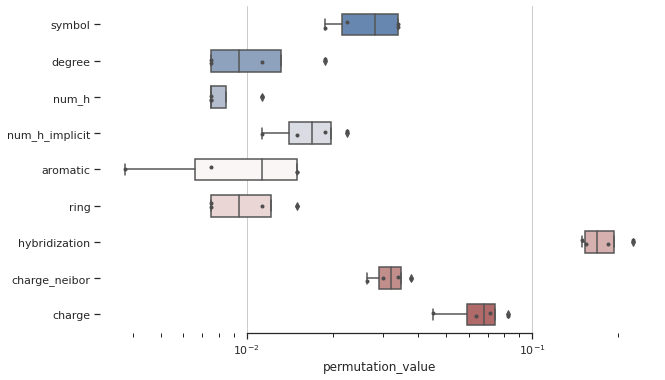

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale("log")

# Load the example planets dataset
# planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="permutation_value", y="feature_name", data=feature_values,
            whis=[0, 50], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="permutation_value", y="feature_name", data=feature_values,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)